In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from datetime import datetime
import time

In [2]:
# Load Dataset
def load_dataset(file_path, test_size=0.2):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    display(df.head())

    # Convert labels to uppercase and map 'BENIGN' to 0, others to 1
    df['Label'] = df['Label'].str.upper()
    df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

    # display(df.head())

    # Feature matrix (X) and target variable (y)
    X = df.drop(columns=['Label'])
    y = df['Label']

    # Shuffle the dataset
    X, y = shuffle(X, y, random_state=42)  # random_state for reproducibility

    # display(X.head())
    # display(y.head())

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42, stratify=y)

    # display(pd.DataFrame(X_scaled, columns=X.columns).head())

    return X_train, X_test, y_train, y_test

In [3]:
# Load data
X_train, X_test, y_train, y_test = load_dataset('/content/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [4]:
# Deep Q-Network (DQN) Agent
class DQNAgent:
    def __init__(self, input_shape, output_shape):
        self.state_size = input_shape
        self.action_size = output_shape
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Input(shape=(self.state_size,)),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(np.array([next_state]), verbose=0)[0]))
            target_f = self.model.predict(np.array([state]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# Initialize DQN agent
dqn_agent = DQNAgent(X_train.shape[1], 2)

In [6]:
# Define the Model
def train_dqn(X, y, agent, episodes=100, batch_size=32):
    training_start_time = time.time()
    for episode in range(episodes):
        episode_start_time = time.time()
        # Iterate using enumerate to get both index and value
        for i, state in enumerate(X):
            action = agent.act(state)
            # Access y using iloc to handle potential index mismatch
            reward = 1 if action == y.iloc[i] else -1
            next_state = X[i] if i == len(X) - 1 else X[i + 1]
            done = i == len(X) - 1
            agent.remember(state, action, reward, next_state, done)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        episode_end_time = time.time()
        print(f"Episode {episode + 1}/{episodes} completed in {(episode_end_time - episode_start_time):.0f} seconds")
    training_end_time = time.time()
    print(f"Training completed in {(training_end_time - training_start_time):.0f} seconds")

In [7]:
# Train the Model
train_dqn(X_train, y_train, dqn_agent, episodes=10)

Episode 1/10 completed in 18 seconds
Episode 2/10 completed in 74 seconds
Episode 3/10 completed in 135 seconds
Episode 4/10 completed in 208 seconds
Episode 5/10 completed in 267 seconds
Episode 6/10 completed in 338 seconds
Episode 7/10 completed in 419 seconds
Episode 8/10 completed in 477 seconds
Episode 9/10 completed in 545 seconds
Episode 10/10 completed in 609 seconds
Training completed in 3089 seconds


In [8]:
# Print Evaluation Metrics
def print_evaluation_metrics(y, y_pred, attack_name):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])

    tn, fp, fn, tp = cm.ravel()

    print(f"{attack_name} - True Positives (TP): {tp}")
    print(f"{attack_name} - False Positives (FP): {fp}")
    print(f"{attack_name} - False Negatives (FN): {fn}")
    print(f"{attack_name} - True Negatives (TN): {tn}")
    print()
    print(f"{attack_name} - Accuracy: {accuracy}")
    print(f"{attack_name} - Precision: {precision}")
    print(f"{attack_name} - Recall: {recall}")
    print(f"{attack_name} - F1 Score: {f1}")
    print(f"{attack_name} - Specificity: {specificity}")

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix - {attack_name}')

    # Add text annotations for TP, FP, FN, TN with labels
    thresh = cm.max() / 2.  # Threshold for text color (white if background is dark, black if light)
    labels = ['TN', 'FP', 'FN', 'TP']
    values = [tn, fp, fn, tp]

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Place the label and value text
            label_value = f'{labels[i*2+j]}: {cm[i, j]}'
            plt.text(j, i, label_value, ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.show()

In [9]:
# Generate FGSM Attack Samples
def attack_fgsm(model, X, y, epsilon=0.1):
    X_var = tf.Variable(X)
    with tf.GradientTape() as tape:
        tape.watch(X_var)
        predictions = model(X_var)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)

    gradient = tape.gradient(loss, X_var)
    X_adv = X + epsilon * tf.sign(gradient)
    return np.clip(X_adv.numpy(), X.min(), X.max())

In [10]:
# Generate PGD Attack Samples
def attack_pgd(model, X, y, epsilon=0.1, alpha=0.01, iterations=10):
    X_adv = X.copy()
    for _ in range(iterations):
        X_var = tf.Variable(X_adv)
        with tf.GradientTape() as tape:
            tape.watch(X_var)
            predictions = model(X_var)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)

        gradient = tape.gradient(loss, X_var)
        X_adv += alpha * tf.sign(gradient.numpy())
        X_adv = np.clip(X_adv, X - epsilon, X + epsilon)
    return X_adv

In [11]:
# Generate ZOO Attack Samples
def attack_zoo(X):
    return X + np.random.normal(0, 0.02, X.shape)

In [12]:
# Define Model For Non-Adversarial Attack
def evaluate_model(agent, X, y):
    evaluation_start_time = time.time()
    y_pred = [agent.act(state) for state in X]
    print_evaluation_metrics(y, y_pred, 'Model Evaluation')
    print()
    evaluation_end_time = time.time()
    print(f"Evaluation Without Adversarial Attack completed in {(evaluation_end_time - evaluation_start_time):.0f} seconds")

Model Evaluation - True Positives (TP): 206
Model Evaluation - False Positives (FP): 15898
Model Evaluation - False Negatives (FN): 230
Model Evaluation - True Negatives (TN): 17713

Model Evaluation - Accuracy: 0.5263018768173408
Model Evaluation - Precision: 0.012791852955787383
Model Evaluation - Recall: 0.4724770642201835
Model Evaluation - F1 Score: 0.0249093107617896
Model Evaluation - Specificity: 0.5270000892564934


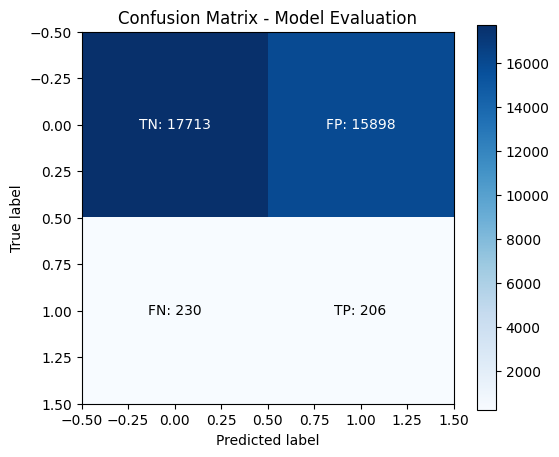


Evaluation Without Adversarial Attack completed in 173 seconds


In [13]:
# Evaluate Model For Non-Adversarial Attack
evaluate_model(dqn_agent, X_test, y_test)

In [14]:
# Define Model for FGSM Attack
def evaluate_fgsm(agent, X, y, epsilon=0.1):
    evaluation_start_time = time.time()
    X_adv = attack_fgsm(agent.model, X, y, epsilon)
    y_pred = [agent.act(state) for state in X_adv]
    print_evaluation_metrics(y, y_pred, 'FGSM Attack')
    print()
    evaluation_end_time = time.time()
    print(f"Evaluation of FGSM Attack completed in {(evaluation_end_time - evaluation_start_time):.0f} seconds")

FGSM Attack - True Positives (TP): 213
FGSM Attack - False Positives (FP): 15854
FGSM Attack - False Negatives (FN): 223
FGSM Attack - True Negatives (TN): 17757

FGSM Attack - Accuracy: 0.5277998061503216
FGSM Attack - Precision: 0.013256986369577395
FGSM Attack - Recall: 0.48853211009174313
FGSM Attack - F1 Score: 0.025813488456644246
FGSM Attack - Specificity: 0.5283091844931719


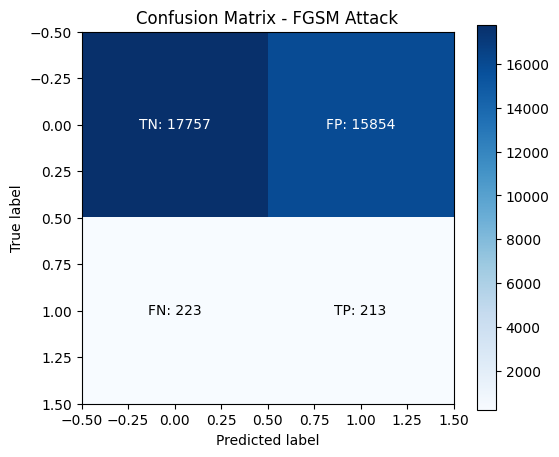


Evaluation of FGSM Attack completed in 181 seconds


In [15]:
# Evaluate Model for FGSM Attack
evaluate_fgsm(dqn_agent, X_test, y_test)

In [16]:
# Define Model for PGD Attack
def evaluate_pgd(agent, X, y, epsilon=0.1, alpha=0.01, iterations=10):
    evaluation_start_time = time.time()
    X_adv = attack_pgd(agent.model, X, y, epsilon, alpha, iterations)
    y_pred = [agent.act(state) for state in X_adv]
    print_evaluation_metrics(y, y_pred, 'PGD Attack')
    print()
    evaluation_end_time = time.time()
    print(f"Evaluation of PGD Attack completed in {(evaluation_end_time - evaluation_start_time):.0f} seconds")

PGD Attack - True Positives (TP): 212
PGD Attack - False Positives (FP): 16007
PGD Attack - False Negatives (FN): 224
PGD Attack - True Negatives (TN): 17604

PGD Attack - Accuracy: 0.5232766469879871
PGD Attack - Precision: 0.013071089462975522
PGD Attack - Recall: 0.48623853211009177
PGD Attack - F1 Score: 0.02545782047433203
PGD Attack - Specificity: 0.5237571033292672


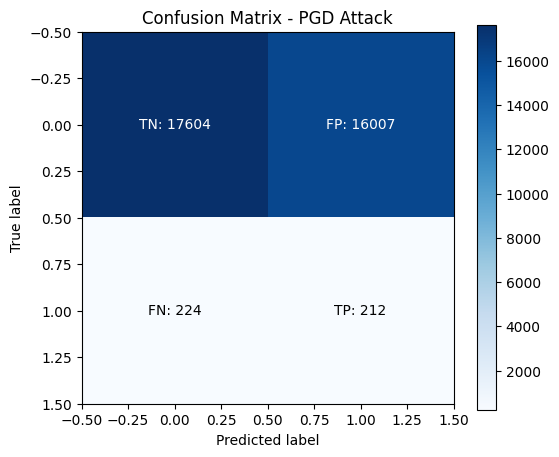


Evaluation of PGD Attack completed in 182 seconds


In [17]:
# Evaluate Model for PGD Attack
evaluate_pgd(dqn_agent, X_test, y_test)

In [18]:
# Define Model for ZOO Attack
def evaluate_zoo(agent, X, y):
    evaluation_start_time = time.time()
    X_adv = attack_zoo(X)
    y_pred = [agent.act(state) for state in X_adv]
    print_evaluation_metrics(y, y_pred, 'ZOO Attack')
    print()
    evaluation_end_time = time.time()
    print(f"Evaluation of ZOO Attack completed in {(evaluation_end_time - evaluation_start_time):.0f} seconds")

ZOO Attack - True Positives (TP): 200
ZOO Attack - False Positives (FP): 15924
ZOO Attack - False Negatives (FN): 236
ZOO Attack - True Negatives (TN): 17687

ZOO Attack - Accuracy: 0.5253619995888037
ZOO Attack - Precision: 0.012403870007442322
ZOO Attack - Recall: 0.45871559633027525
ZOO Attack - F1 Score: 0.024154589371980676
ZOO Attack - Specificity: 0.5262265329802743


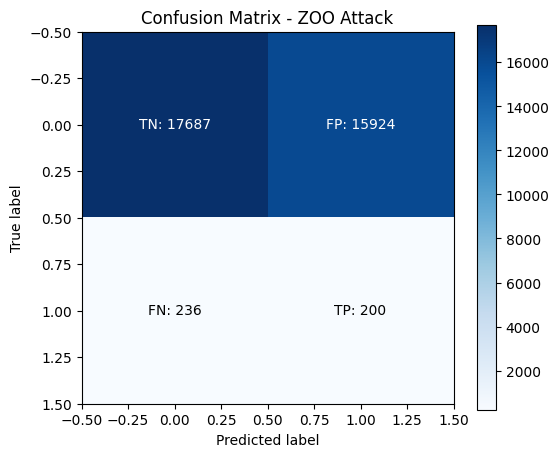


Evaluation of ZOO Attack completed in 176 seconds


In [19]:
# Evaluate Model for ZOO Attack
evaluate_zoo(dqn_agent, X_test, y_test)